In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import math
from datetime import datetime

#### Import Kestrel data and change year to 2015

In [2]:
dtypes=[datetime, float]
kes15 = pd.read_excel('Kestrel_data2015.xlsx',names=['time','ws'],header=3)
kes15['time']=kes15['time'].apply((lambda x: x.replace(year=2015)))


start_date = pd.Timestamp(2015,3,11,12,30,0)
end_date = pd.Timestamp(2015,3,11,13,5,0)
mask1 = (kes15['time'] > start_date) & (kes15['time'] <= end_date)
kes15_1 = kes15.loc[mask1]


start_date = pd.Timestamp(2015,3,11,13,10,0)
end_date = pd.Timestamp(2015,3,11,13,30,0)
mask2=(kes15['time'] > start_date) & (kes15['time'] <= end_date)
kes15_2 = kes15.loc[mask2]


#### Import 2015 Pitot data 

In [3]:
pit15_1 = pd.read_csv('WindTunnelCalibration2015_test1.csv',header=0)
pit15_1.columns = ['time','fan_rpm','air_temp','air_dens','press','ws']
pit15_1['time']=pit15_1['time'].apply((lambda x: pd.to_datetime(x[-5:])))
pit15_1['time']=pit15_1['time'].apply((lambda x: x.replace(year=2015)))
pit15_1['time']=pit15_1['time'].apply((lambda x: x.replace(month=3)))
pit15_1['time']=pit15_1['time'].apply((lambda x: x.replace(day=11)))

In [4]:
pit15_2=pd.read_csv('WindTunnelCalibration2015_test2.csv',header=0)
pit15_2.columns = ['time','fan_rpm','air_temp','air_dens','press','ws']
pit15_2['time']=pit15_2['time'].apply((lambda x: pd.to_datetime(x[-5:])))
pit15_2['time']=pit15_2['time'].apply((lambda x: x.replace(year=2015)))
pit15_2['time']=pit15_2['time'].apply((lambda x: x.replace(month=3)))
pit15_2['time']=pit15_2['time'].apply((lambda x: x.replace(day=11)))

#### Import 2015 Sonic data 

In [5]:
son15 = pd.read_csv('2015_sonic_1230_start.txt', sep=",", header=None)
son15.columns = ['gu','gv','gw','sound_speed','temp']
N=len(son15)
freq= 10   #Hz
dt= str(1/freq)+'S'   #seconds 
start_time=pd.Timestamp(2015,3,11,12,30,0.0)
time = pd.date_range(start = start_time,periods=N,freq=dt)
son15.insert(0,'time',time,True)
son15 = son15[son15.gu < 20]
son15 = son15[son15.gv < 20]

#### Uncomment to average

In [6]:
# son15_raw.index = pd.DatetimeIndex(son15_raw.time)
# avg_time = '10S'
# gu = (son15_raw['gu'].resample(avg_time).mean())
# gv = (son15_raw['gv'].resample(avg_time).mean())
# gw = (son15_raw['gw'].resample(avg_time).mean())
# sound_speed = (son15_raw['sound_speed'].resample(avg_time).mean())
# temp = (son15_raw['temp'].resample(avg_time).mean())

# data = {'gu':gu, 
#         'gv':gv,
#         'gw':gw,
#         'sound_speed':sound_speed,
#         'temp':temp} 
# son15=pd.DataFrame(data)
# son15.reset_index(drop=False, inplace=True)
# son15.head()

#### Convert Gill to Met

In [7]:
def convert_gill_to_met(gu,gv,gw):
    w = [x for x in gw]
    u = [-x for x in gv]
    v = [x for x in gu]
    
    return [u,v,w]


def find_alpha(u,v):
    dirs=[]
    for i in range(len(u)):
    
        if u[i] > 0:
            alpha = 90 - np.arctan(v[i]/u[i])+180
        elif u[i] < 0:
            alpha = 90 - np.arctan(v[i]/u[i])
        else:
            if v[i]>0:
                alpha = 0
            else:
                alpha = 180
            
        dirs.append(alpha)

    return dirs


def mean_horizontal_wind(u,v):
    mean_winds=[]
    for i in range(len(u)):
        M = np.sqrt((u[i])**2 + (v[i])**2)
        mean_winds.append(M)
    return mean_winds

In [8]:
met_dirs15 = convert_gill_to_met(son15['gu'],son15['gv'],son15['gw'])
u15=met_dirs15[0]
v15=met_dirs15[1]
w15=met_dirs15[2]
M15 = mean_horizontal_wind(u15,v15)
son15.insert(1,'u',u15,True)
son15.insert(2,'v',v15,True)
son15.insert(3,'w',w15,True)
son15.insert(4,'mean_wind',M15,True)
son15.head()

,time,u,v,w,mean_wind,gu,gv,gw,sound_speed,temp
0,2015-03-11 12:30:00.000,2.10,-0.08,0.01,2.101523,-0.08,-2.10,0.01,343.95,20.56
1,2015-03-11 12:30:00.100,2.12,-0.09,0.01,2.121910,-0.09,-2.12,0.01,343.95,20.56
2,2015-03-11 12:30:00.200,2.12,-0.10,0.01,2.122357,-0.10,-2.12,0.01,343.96,20.57
3,2015-03-11 12:30:00.300,2.13,-0.12,0.01,2.133378,-0.12,-2.13,0.01,343.96,20.57
4,2015-03-11 12:30:00.400,2.14,-0.14,0.01,2.144575,-0.14,-2.14,0.01,343.97,20.59


In [9]:
start_date = pd.Timestamp(2015,3,11,12,30,00.000)
end_date = pd.Timestamp(2015,3,11,13,5,00.000)
mask1 = (son15['time'] > start_date) & (son15['time'] <= end_date)
son15_1 = son15.loc[mask1]


start_date = pd.Timestamp(2015,3,11,13,10,00.000)
end_date = pd.Timestamp(2015,3,11,13,30,00.000)
mask2=(son15['time'] > start_date) & (son15['time'] <= end_date)
son15_2 = son15.loc[mask2]

#### Plot wind trace for test 1 2015

c:\users\pearl\miniconda3\envs\e350\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5,1,'Wind Speed Traces Test 1 2015')

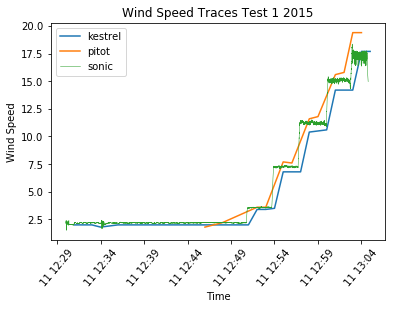

In [10]:
plt.plot(kes15_1['time'],kes15_1['ws'])
plt.plot(pit15_1['time'],pit15_1['ws'])
plt.plot(son15_1['time'],son15_1['mean_wind'],linewidth =0.51)
plt.legend(['kestrel','pitot','sonic'])
plt.xticks(rotation=50)
plt.ylabel('Wind Speed')
plt.xlabel('Time')
plt.title('Wind Speed Traces Test 1 2015')

Text(0.5,1,'Wind Speed Traces Test 2 2015')

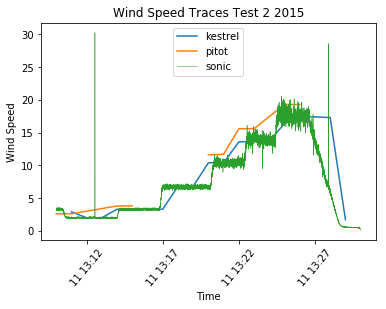

In [11]:
plt.plot(kes15_2['time'],kes15_2['ws'])
plt.plot(pit15_2['time'],pit15_2['ws'])
plt.plot(son15_2['time'],son15_2['mean_wind'],linewidth =0.51)
plt.legend(['kestrel','pitot','sonic'])
plt.xticks(rotation=50)
plt.ylabel('Wind Speed')
plt.xlabel('Time')
plt.title('Wind Speed Traces Test 2 2015')

#### Import 2020 Kestrel data 

In [12]:
kes20=pd.read_csv('kestrel_2020.csv',header=0)
kes20.columns = ['time','ws']
freq=0.2  #Hz
kes20.head()

,time,ws
0,2020-03-06 11:49,0.0
1,2020-03-06 11:49,0.0
2,2020-03-06 11:49,0.0
3,2020-03-06 11:49,0.0
4,2020-03-06 11:49,0.0


#### Import 2020 Sonic data 

In [13]:
son20 = pd.read_csv('sonic_2020.csv', header=None)
son20.columns = ['gu','gv','gw','sound_speed','temp']
N=len(son20)
freq= 10   #Hz
dt= str(1/freq)+'S'   #seconds 

# T=len(son20)*dt   #seconds
# start_time=pd.Timestamp(2020,3,6,11,49,0.0)
# end_time = start_time + pd.Timedelta(seconds=T)

start_time=kes20['time'][0]
time = pd.date_range(start = start_time,periods=N,freq=dt)
son20.insert(0,'time',time,True)
son20.head()

,time,gu,gv,gw,sound_speed,temp
0,2020-03-06 11:49:00.000,0.03,0.03,-0.04,345.00,22.34
1,2020-03-06 11:49:00.100,0.03,0.03,-0.05,345.01,22.36
2,2020-03-06 11:49:00.200,0.02,0.03,-0.04,345.01,22.36
3,2020-03-06 11:49:00.300,0.02,0.03,-0.04,345.01,22.36
4,2020-03-06 11:49:00.400,0.02,0.02,-0.04,345.01,22.36


In [14]:
met_dirs20 = convert_gill_to_met(son20['gu'],son20['gv'],son20['gw'])
u20=met_dirs20[0]
v20=met_dirs20[1]
w20=met_dirs20[2]
M20 = mean_horizontal_wind(u20,v20)
son20.insert(1,'u',u20,True)
son20.insert(2,'v',v20,True)
son20.insert(3,'w',w20,True)
son20.insert(4,'mean_wind',M20,True)
son20.head()

,time,u,v,w,mean_wind,gu,gv,gw,sound_speed,temp
0,2020-03-06 11:49:00.000,-0.03,0.03,-0.04,0.042426,0.03,0.03,-0.04,345.00,22.34
1,2020-03-06 11:49:00.100,-0.03,0.03,-0.05,0.042426,0.03,0.03,-0.05,345.01,22.36
2,2020-03-06 11:49:00.200,-0.03,0.02,-0.04,0.036056,0.02,0.03,-0.04,345.01,22.36
3,2020-03-06 11:49:00.300,-0.03,0.02,-0.04,0.036056,0.02,0.03,-0.04,345.01,22.36
4,2020-03-06 11:49:00.400,-0.02,0.02,-0.04,0.028284,0.02,0.02,-0.04,345.01,22.36
